In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_csv("/content/gebalanceerd_bedrijven.csv")

# Zorg dat review_text niet null is
df = df[df['review_text'].notnull()]
df['review_text'] = df['review_text'].fillna('')

# de bewuste group by
grouped = df.groupby("place_id").agg({
    "review_text": lambda x: " ".join(x.dropna()),
    "review_rating": "mean",
    "author_reviews_count": "mean",
    "author_ratings_count": "mean",
    "fraud": "max"
}).reset_index()

df_fraud = grouped[grouped['fraud'] == 1]
df_nonfraud = grouped[grouped['fraud'] == 0]
n_samples = min(len(df_fraud), len(df_nonfraud))

# eigenlijk niet meer nodig
df_balanced = pd.concat([
    df_fraud.sample(n=n_samples, random_state=42),
    df_nonfraud.sample(n=n_samples, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
text_data = df_balanced["review_text"].tolist()
labels = df_balanced["fraud"].values

meta_cols = ['review_rating', 'author_reviews_count', 'author_ratings_count']
df_balanced[meta_cols] = df_balanced[meta_cols].fillna(0)
scaler = StandardScaler()
meta_features = scaler.fit_transform(df_balanced[meta_cols])

# Train/test-split
X_train_text, X_test_text, X_train_meta, X_test_meta, y_train, y_test = train_test_split(
    text_data, meta_features, labels, test_size=0.2, random_state=42, stratify=labels
)

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, texts, metas, labels, tokenizer, max_len=128):
        self.texts = texts
        self.metas = metas
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'meta': torch.tensor(self.metas[idx], dtype=torch.float),
            'label': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# Model
class BERTFraudClassifier(nn.Module):
    def __init__(self, meta_input_size):
        super(BERTFraudClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc1 = nn.Linear(768 + meta_input_size, 128)
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(128, 1)

    def forward(self, input_ids, attention_mask, meta):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        x = torch.cat((bert_output, meta), dim=1)
        x = self.dropout(torch.relu(self.fc1(x)))
        return torch.sigmoid(self.out(x)).squeeze(-1)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',  use_fast=True)


train_dataset = ReviewDataset(X_train_text, X_train_meta, y_train, tokenizer)
test_dataset = ReviewDataset(X_test_text, X_test_meta, y_test, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BERTFraudClassifier(meta_input_size=X_train_meta.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [ ]:
for epoch in range(3):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        meta = batch['meta'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, meta)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")

Epoch 1 Loss: 0.5575
Epoch 2 Loss: 0.4428
Epoch 3 Loss: 0.4169


Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.97      0.83       117
         1.0       0.95      0.64      0.77       117

    accuracy                           0.80       234
   macro avg       0.84      0.80      0.80       234
weighted avg       0.84      0.80      0.80       234

ROC AUC: 0.8663890715172766


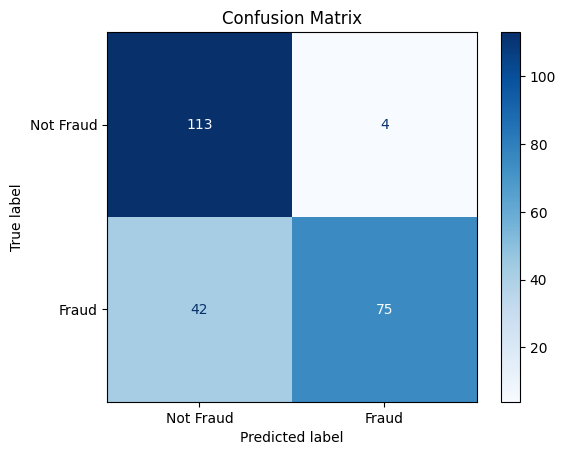

In [ ]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        meta = batch['meta'].to(device)
        labels = batch['label'].cpu().numpy()
        outputs = model(input_ids, attention_mask, meta).cpu().numpy()
        all_preds.extend(outputs)
        all_labels.extend(labels)

preds_bin = [1 if p >= 0.5 else 0 for p in all_preds]
print("Classification Report:")
print(classification_report(all_labels, preds_bin))
print("ROC AUC:", roc_auc_score(all_labels, all_preds))

cm = confusion_matrix(all_labels, preds_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()